In [19]:
import pandas as pd
import os
import time
from datetime import timedelta, datetime
from dateutil import parser
import math
from tqdm import tqdm_notebook
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [20]:
df = pd.read_csv('data/BTCUSDT-1m-1Jun2020to1Dec2020data.csv')
df.head()

df.tail(10)

,Timestamp,Open,High,Low,Close,Volume,Close_time,Quote_av,Trades,Tb_base_av,Tb_quote_av,Ignore
263242,2020-11-30 23:52:00,19744.00,19744.99,19740.22,19744.48,60.573448,1606780379999,1.195970e+06,986,41.370690,8.168287e+05,0
263243,2020-11-30 23:53:00,19744.49,19744.99,19699.52,19718.28,119.123054,1606780439999,2.349155e+06,1683,68.558198,1.351917e+06,0
263244,2020-11-30 23:54:00,19718.28,19736.03,19625.05,19641.37,97.284917,1606780499999,1.915027e+06,2217,37.528715,7.392528e+05,0
263245,2020-11-30 23:55:00,19641.37,19697.58,19637.04,19663.31,112.950287,1606780559999,2.221748e+06,2162,65.823884,1.294934e+06,0
263246,2020-11-30 23:56:00,19663.25,19672.28,19635.00,19656.01,80.342827,1606780619999,1.579052e+06,1776,34.951323,6.869545e+05,0
263247,2020-11-30 23:57:00,19656.01,19686.37,19650.00,19655.99,58.163503,1606780679999,1.143874e+06,1151,29.788851,5.858160e+05,0
263248,2020-11-30 23:58:00,19656.10,19679.00,19647.83,19658.33,84.698943,1606780739999,1.665254e+06,1482,31.676067,6.227900e+05,0
263249,2020-11-30 23:59:00,19658.33,19700.00,19656.82,19695.87,136.845571,1606780799999,2.693831e+06,1708,95.473753,1.879199e+06,0
263250,2020-12-01 00:00:00,19695.87,19720.00,19675.43,19715.93,136.104435,1606780859999,2.681137e+06,1828,72.113618,1.420672e+06,0
263251,2020-12-01 00:00:00,19695.87,19720.00,19675.43,19715.93,136.104435,1606780859999,2.681137e+06,1828,72.113618,1.420672e+06,0


In [21]:
# Drop columns that we won't use
df = df.drop('Close_time', 1)
df = df.drop('Quote_av', 1)
df = df.drop('Trades', 1)
df = df.drop('Tb_base_av', 1)
df = df.drop('Tb_quote_av', 1)
df = df.drop('Ignore', 1)

df.tail(10)

,Timestamp,Open,High,Low,Close,Volume
263242,2020-11-30 23:52:00,19744.00,19744.99,19740.22,19744.48,60.573448
263243,2020-11-30 23:53:00,19744.49,19744.99,19699.52,19718.28,119.123054
263244,2020-11-30 23:54:00,19718.28,19736.03,19625.05,19641.37,97.284917
263245,2020-11-30 23:55:00,19641.37,19697.58,19637.04,19663.31,112.950287
263246,2020-11-30 23:56:00,19663.25,19672.28,19635.00,19656.01,80.342827
263247,2020-11-30 23:57:00,19656.01,19686.37,19650.00,19655.99,58.163503
263248,2020-11-30 23:58:00,19656.10,19679.00,19647.83,19658.33,84.698943
263249,2020-11-30 23:59:00,19658.33,19700.00,19656.82,19695.87,136.845571
263250,2020-12-01 00:00:00,19695.87,19720.00,19675.43,19715.93,136.104435
263251,2020-12-01 00:00:00,19695.87,19720.00,19675.43,19715.93,136.104435


In [22]:
# Produce training samples to predict future from past.
def sampler(P, F, A, sliding_window=True):
    number_of_samples = P + F
    
    if sliding_window:
        I = np.arange(number_of_samples) + np.arange(A.shape[0] - number_of_samples + 1).reshape(-1, 1)
    else:
        if A.shape[0] % number_of_samples == 0:
            I = np.arange(number_of_samples) + np.arange(0, A.shape[0], number_of_samples).reshape(-1, 1)
        else:
            I = np.arange(number_of_samples) + np.arange(0, A.shape[0] - number_of_samples, number_of_samples).reshape(-1, 1)
            
    B = A[I].reshape(-1, number_of_samples * A.shape[1], A.shape[2])
    number_of_features = P * A.shape[1]
    sample_matrix = B[:, :number_of_features]
    target_matrix = B[:, number_of_features:]
    
    return sample_matrix, target_matrix


data_file = 'data/BTCUSDT-1m-1Jun2020to1Dec2020data.csv'
df = pd.read_csv(data_file)

# Drop columns that we won't use
df = df.drop('Close_time', 1)
df = df.drop('Quote_av', 1)
df = df.drop('Trades', 1)
df = df.drop('Tb_base_av', 1)
df = df.drop('Tb_quote_av', 1)
df = df.drop('Ignore', 1)

df.tail(10)

,Timestamp,Open,High,Low,Close,Volume
263242,2020-11-30 23:52:00,19744.00,19744.99,19740.22,19744.48,60.573448
263243,2020-11-30 23:53:00,19744.49,19744.99,19699.52,19718.28,119.123054
263244,2020-11-30 23:54:00,19718.28,19736.03,19625.05,19641.37,97.284917
263245,2020-11-30 23:55:00,19641.37,19697.58,19637.04,19663.31,112.950287
263246,2020-11-30 23:56:00,19663.25,19672.28,19635.00,19656.01,80.342827
263247,2020-11-30 23:57:00,19656.01,19686.37,19650.00,19655.99,58.163503
263248,2020-11-30 23:58:00,19656.10,19679.00,19647.83,19658.33,84.698943
263249,2020-11-30 23:59:00,19658.33,19700.00,19656.82,19695.87,136.845571
263250,2020-12-01 00:00:00,19695.87,19720.00,19675.43,19715.93,136.104435
263251,2020-12-01 00:00:00,19695.87,19720.00,19675.43,19715.93,136.104435


In [23]:
columns = ['Close']
o_df = df
time_stamps = df['Timestamp']
df = df.loc[:,columns]
real_df = o_df.loc[:,columns]

real_df### Normalize The Data with MinMax Normalization

,Close
0,9439.58
1,9442.04
2,9443.08
3,9421.86
4,9432.64
...,...
263247,19655.99
263248,19658.33
263249,19695.87
263250,19715.93


### Normalize The Data with MinMax Normalization

In [24]:
# Normalize the data with min - max normalization
scaler = MinMaxScaler()

for c in columns:
    df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))
    
df

,Close
0,0.052724
1,0.052948
2,0.053043
3,0.051110
4,0.052092
...,...
263247,0.983166
263248,0.983379
263249,0.986798
263250,0.988625


In [25]:
file_name='BTCUSDT-1m-1Jun2020to1Dec2020data.h5'

# Features are backward sample dimensions
close_data = np.array(df)[:,None,:]
print('A', close_data)

real_close_data = np.array(real_df)[:,None,:]
print('real_A', real_close_data)

time_stamps = np.array(time_stamps)[:,None,None]
print('time_stamps', time_stamps)

number_of_backwards = 256
number_of_forwards = 16

# Pass preprocessed close data to the sampler
X, y = sampler(number_of_backwards, number_of_forwards, close_data, sliding_window=False)
print('Data', X)
print('Labels', y)

# Pass timestamps to the sampler
backward_times, forward_times = sampler(number_of_backwards, number_of_forwards, time_stamps, sliding_window=False)

# Pass real close data to the sampler
real_X, real_Y = sampler(number_of_backwards, number_of_forwards, real_close_data, sliding_window=False)

real_close_data = np.array(real_df)
real_backwards = np.array(real_X)
real_forwards = np.array(real_Y)

A [[[0.05272414]]

 [[0.05294818]]

 [[0.05304289]]

 ...

 [[0.98679802]]

 [[0.98862495]]

 [[0.98862495]]]
real_A [[[ 9439.58]]

 [[ 9442.04]]

 [[ 9443.08]]

 ...

 [[19695.87]]

 [[19715.93]]

 [[19715.93]]]
time_stamps [[['2020-06-01 00:00:00']]

 [['2020-06-01 00:01:00']]

 [['2020-06-01 00:02:00']]

 ...

 [['2020-11-30 23:59:00']]

 [['2020-12-01 00:00:00']]

 [['2020-12-01 00:00:00']]]
Data [[[0.05272414]
  [0.05294818]
  [0.05304289]
  ...
  [0.06523578]
  [0.06549261]
  [0.06669478]]

 [[0.06359373]
  [0.063489  ]
  [0.06332507]
  ...
  [0.06256187]
  [0.0623269 ]
  [0.06249812]]

 [[0.06268938]
  [0.0625983 ]
  [0.06231689]
  ...
  [0.06332507]
  [0.06257371]
  [0.06332689]]

 ...

 [[0.88523402]
  [0.88464295]
  [0.88527955]
  ...
  [0.88023409]
  [0.87946088]
  [0.87898275]]

 [[0.88589066]
  [0.88716022]
  [0.88868023]
  ...
  [0.98774245]
  [0.98518056]
  [0.98133818]]

 [[0.97337746]
  [0.97050774]
  [0.96718812]
  ...
  [0.94541797]
  [0.94181602]
  [0.94298085]]]
La

### Linear Regression

In [30]:
training_size = int(X.shape[0] * 0.8)
Xt = X[:training_size,:,:]
yt = y[:training_size,:,0]
Xv = X[training_size:,:,:]
yv = y[training_size:,:,0]

real_forwards_val = real_forwards[training_size:,:,:]
real_backwards_val = real_backwards[training_size:,:,:]
backward_times_val = backward_times[training_size:,:,:]
forward_times_val = forward_times[training_size:,:,:]

real_chart_lr = np.append(real_backwards_val, real_forwards_val, axis=1)
real_chart_times_lr = np.append(backward_times_val, forward_times_val, axis=1)

print(Xt.shape, yt.shape)

prediction = np.zeros(yv.shape)
for i in range(16):
    linear_regression = LinearRegression()
    linear_regression.fit(Xt[:,:,0], yt[:,i])
    prediction[:,i] = linear_regression.predict(Xv[:,:,0])
    
print(prediction.shape)

# Inverse transform for prediction
inverted_prediction = []
scaler.fit(real_close_data[:,0].reshape(-1, 1))
inverted_prediction.append(scaler.inverse_transform(prediction))

(773, 256, 1) (773, 16)
(194, 16)


### Plot the result

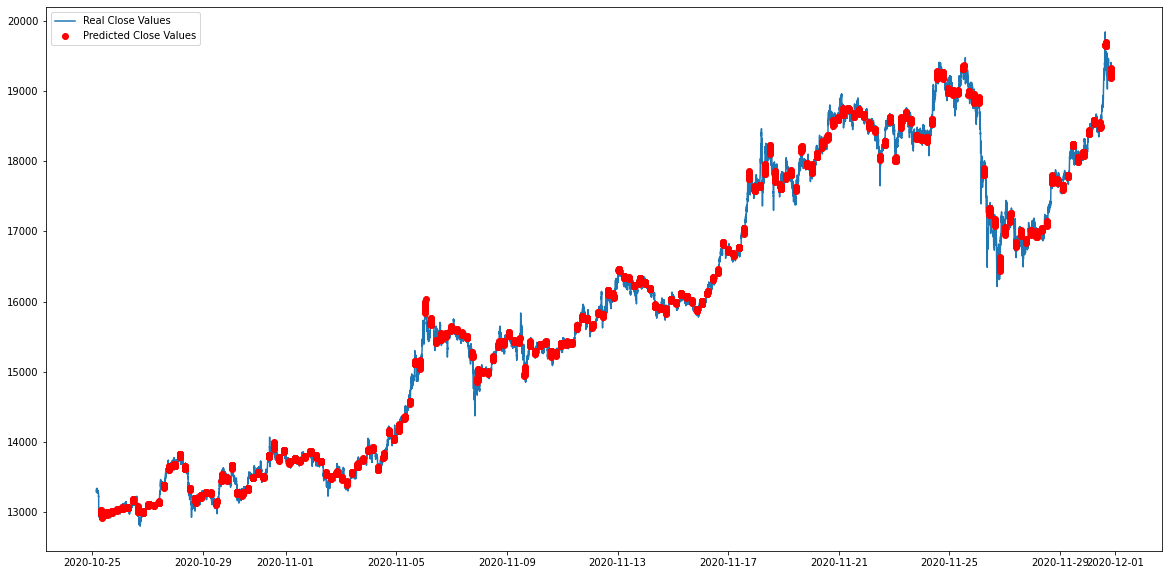

In [31]:
# Real values for chart
real_chart_lr = real_chart_lr[:,:,0].reshape(-1)

real_chart_times_lr = real_chart_times_lr.reshape(-1)
real_chart_times_lr = pd.to_datetime(real_chart_times_lr, unit='ns')

inverted_prediction = np.array(inverted_prediction)[0,:,:].reshape(-1)
forward_times_val = pd.to_datetime(forward_times_val.reshape(-1), unit='ns')

real_chart_lr_df = pd.DataFrame()
real_chart_lr_df['close'] = real_chart_lr
real_chart_lr_df['times'] = real_chart_times_lr
real_chart_lr_df.set_index('times').reset_index()

prediction_df = pd.DataFrame()
prediction_df['close'] = inverted_prediction
prediction_df['times'] = forward_times_val


plt.figure(figsize=(20, 10))
plt.plot(real_chart_lr_df.times, real_chart_lr_df.close, label='Real Close Values')
plt.plot(prediction_df.times, prediction_df.close, 'ro', label='Predicted Close Values')
plt.legend(loc='upper left')
plt.savefig('linearregression.png')
plt.show()

In [35]:
# Get real_close_values
future_predict = pd.DataFrame(o_df['Close'])

# Scale minmax transform
for c in columns:
    future_predict[c] = scaler.fit_transform(future_predict[c].values.reshape(-1,1))

# Get last backwards 256
future_predict = np.array([future_predict[-512:-256]])
print('Backward input shape: ',future_predict[0].shape)

# Predict
#predicted_future = model.predict(future_predict)
predicted_future = np.zeros(yv.shape)
for i in range(16):
    linear_regression = LinearRegression()
    linear_regression.fit(Xt[:,:,0], yt[:,i])
    predicted_future[:,i] = linear_regression.predict(future_predict[:,:,0])

# Inverse Transform
predicted_future_inverted = []
scaler.fit(real_close_data[:,0].reshape(-1, 1))
predicted_future_inverted.append(scaler.inverse_transform(predicted_future))
    
predicted_future_inverted = np.array(predicted_future_inverted)

future_df = pd.DataFrame()
future_df['value'] =  (predicted_future_inverted[0])[0]



future_df


Backward input shape:  (256, 1)
[[[19247.61928671 19252.76540352 19213.36917844 ... 19339.98381116
   19337.63020887 19331.27806828]
  [19247.61928671 19252.76540352 19213.36917844 ... 19339.98381116
   19337.63020887 19331.27806828]
  [19247.61928671 19252.76540352 19213.36917844 ... 19339.98381116
   19337.63020887 19331.27806828]
  ...
  [19247.61928671 19252.76540352 19213.36917844 ... 19339.98381116
   19337.63020887 19331.27806828]
  [19247.61928671 19252.76540352 19213.36917844 ... 19339.98381116
   19337.63020887 19331.27806828]
  [19247.61928671 19252.76540352 19213.36917844 ... 19339.98381116
   19337.63020887 19331.27806828]]]
[19247.61928671 19252.76540352 19213.36917844 19240.86569496
 19261.51181856 19234.06946542 19197.17980068 19203.35124006
 19212.95173114 19246.80628797 19275.47887537 19327.57635461
 19338.15317316 19339.98381116 19337.63020887 19331.27806828]


,value
0,19247.619287
1,19252.765404
2,19213.369178
3,19240.865695
4,19261.511819
5,19234.069465
6,19197.179801
7,19203.351240
8,19212.951731
9,19246.806288


16
0    2020-11-30 19:46:00
1    2020-11-30 19:47:00
2    2020-11-30 19:48:00
3    2020-11-30 19:49:00
4    2020-11-30 19:50:00
5    2020-11-30 19:51:00
6    2020-11-30 19:52:00
7    2020-11-30 19:53:00
8    2020-11-30 19:54:00
9    2020-11-30 19:55:00
10   2020-11-30 19:56:00
11   2020-11-30 19:57:00
12   2020-11-30 19:58:00
13   2020-11-30 19:59:00
14   2020-11-30 20:00:00
15   2020-11-30 20:01:00
Name: timestamps, dtype: datetime64[ns]
AAAA
AAAA


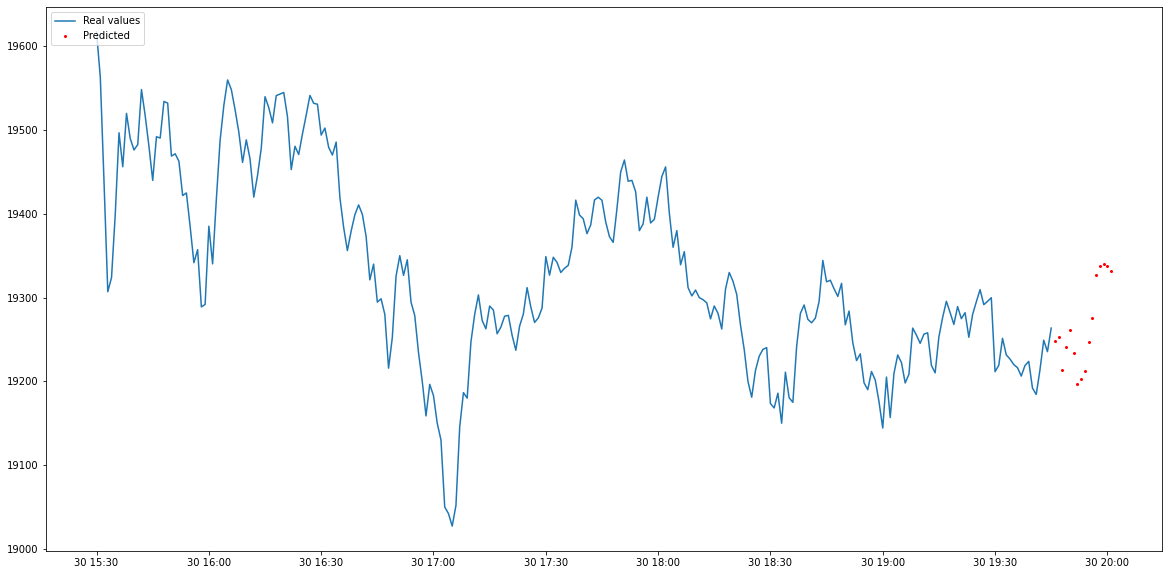

0      19617.35
1      19563.49
2      19437.66
3      19307.08
4      19323.91
         ...   
251    19184.33
252    19213.72
253    19249.14
254    19235.46
255    19263.60
Name: close, Length: 256, dtype: float64

In [38]:
o_df_2048 = o_df[-512:-256]
o_df_2048


real_8192 = pd.DataFrame()
real_8192['timestamps'] = pd.to_datetime(np.array(o_df_2048['Timestamp']).reshape(-1), unit='ns')
real_8192['close'] = np.array(o_df_2048['Close'])

o_df_512_256 = o_df[-256:-240]
print(len(o_df_512_256['Timestamp']))
time_512_256 = pd.DataFrame()
time_512_256['timestamps'] = pd.to_datetime(np.array(o_df_512_256['Timestamp']).reshape(-1), unit='ns')
print(time_512_256['timestamps'])
print("AAAA")

plt.figure(figsize=(20,10))
print("AAAA")
plt.plot(real_8192.timestamps, real_8192.close, label='Real values')

#plt.plot(real_chart_df.times, real_chart_df.value, label = 'Actual')
plt.plot(time_512_256.timestamps, future_df.value, 'ro', label='Predicted', markersize=2)
plt.legend(loc='upper left')
plt.show()

prediction_df['times'][0]
real_8192['close']